In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import Tokenizer, Word2Vec

# these imports are how we build and manager our data science processes: cleaning data, preparing a model,
# executing the model, and evaluating the model.
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

In [2]:
# we use a set of constants for clarity and simplicity in managing the notebook.
# this allows you to refer back to this cell at any time if you need to either confirm or modify any of these values.

DATA_NAME = "Electronics_5.json"
APP_NAME = "Sentiment Analysis with Amazon Reviews Exercise"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

In [3]:
sc = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sqlContext = SQLContext(sc)

In [4]:
amznElectronics = sqlContext.read.json(DATA_NAME)

In [5]:
print(f"Dataset shape is {amznElectronics.count():d} rows by {len(amznElectronics.columns):d} columns.")

Dataset shape is 1689188 rows by 9 columns.


In [6]:
amznElectronics.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [7]:
amznElectronics.registerTempTable('reviews')

In [8]:
sqlContext.sql("select overall, count(overall) as reviewCount from reviews group by overall order by overall desc").show()

+-------+-----------+
|overall|reviewCount|
+-------+-----------+
|    5.0|    1009026|
|    4.0|     347041|
|    3.0|     142257|
|    2.0|      82139|
|    1.0|     108725|
+-------+-----------+



In [9]:
udf = UserDefinedFunction(lambda x: 1 if x > 3.0 else -1, IntegerType())

amznElectronics = amznElectronics.withColumn("overall_recode",udf(amznElectronics.overall))

([<matplotlib.axis.XTick at 0x7fa4d41c8438>,
 <a list of 2 Text xticklabel objects>)

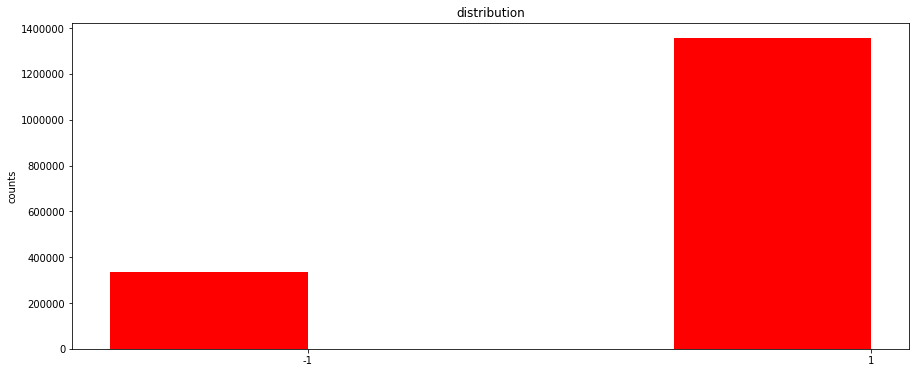

In [10]:
plt.rcParams['figure.figsize'] = (15, 6)
 
statuses = amznElectronics.groupBy('overall_recode').count().collect()

categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('distribution')
plt.xticks(ind + width/2., categories)

In [11]:
amznElectronics.select("overall", "overall_recode", "summary", "reviewText").show(10)

+-------+--------------+--------------------+--------------------+
|overall|overall_recode|             summary|          reviewText|
+-------+--------------+--------------------+--------------------+
|    5.0|             1|     Gotta have GPS!|We got this GPS f...|
|    1.0|            -1|   Very Disappointed|I'm a professiona...|
|    3.0|            -1|      1st impression|Well, what can I ...|
|    2.0|            -1|Great grafics, PO...|Not going to writ...|
|    1.0|            -1|Major issues, onl...|I've had mine for...|
|    5.0|             1|HDMI Nook adapter...|I am using this w...|
|    2.0|            -1|Cheap proprietary...|The cable is very...|
|    5.0|             1|A Perfdect Nook H...|This adaptor is r...|
|    4.0|             1|A nice easy to us...|This adapter easi...|
|    5.0|             1|This works great ...|This product real...|
+-------+--------------+--------------------+--------------------+
only showing top 10 rows



In [12]:
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokenized_text").transform(amznElectronics)

word2Vec = Word2Vec(vectorSize=300, seed=42, inputCol="tokenized_text", outputCol="w2v_vector").fit(tokenizer)

w2vdf=word2Vec.transform(tokenizer)

Py4JJavaError: An error occurred while calling o80.fit.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.mllib.feature.Word2Vec.doFit(Word2Vec.scala:355)
	at org.apache.spark.mllib.feature.Word2Vec.fit(Word2Vec.scala:319)
	at org.apache.spark.ml.feature.Word2Vec.fit(Word2Vec.scala:187)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
w2vdf.printSchema()

In [ ]:
w2vdf.select("overall_recode", "reviewText", "tokenized_text", "w2v_vector").show(10)

In [ ]:
# Build the training indexers/split data/classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="overall_recode", outputCol="indexedLabel").fit(w2vdf)

# now generate the indexed feature vector.
featureIndexer = VectorIndexer(inputCol="w2v_vector", outputCol="indexedFeatures", maxCategories=4).fit(w2vdf)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = w2vdf.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [ ]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")